# Write custom classes

FESTIM is very flexible. However you may want to customise it further.

You can do this by creating your own classes.

We show here a few examples:
- Creating custom derived quantities
- Reading the temperature from tabulated data
- Add functionalities to the solver

## Compute the advection flux

This example builds upon the previous task **Advection-diffusion problem** where we obtained a hydrodgen concentration field under the influence of a velocity field.

![image](https://github.com/user-attachments/assets/b5da0f24-bfe3-4301-abfe-27ab89aae40a)

We would now like to compute the flux $J$ on the right surface $\Gamma_\mathrm{right}$ including advection:

$$
J = \int_{\Gamma_\mathrm{right}} c \ v \cdot \mathbf{n} \ ds
$$

where $v$ is the velocity vector in $\mathrm{m/s}$, $c$ is the hydrogen concentration in $\mathrm{H/m^3}$, and $\mathbf{n}$ is the outward normal vector.


Just like the advection term in the governing equations, this derived quantity is not natively supported in FESTIM.

It is however possible to make our own ``DerivedQuantity`` class to achieve this result.
For more information on class inheritance in python, have a look at [this tutorial](https://www.w3schools.com/python/python_inheritance.asp).

To do so, let's create a class called ``SurfaceAdvectionFlux`` inheriting from ``festim.SurfaceQuantity``.
By doing so, we can inherit from the existing functionalities of the parent class while adding more and overriding the parent class's behaviour.

This new class will have an argument ``velocity_field`` that will take a ``fenics.Function`` as value.
This will be stored as an _attribute_ of the class so that we can use it in other methods.
We then add the ``compute`` method to compute the correct flux.



In [1]:
import fenics as f
import festim as F


class SurfaceAdvectionFlux(F.SurfaceQuantity):
    def __init__(self, field, surface, velocity_field):

        super().__init__(field=field, surface=surface)

        self.velocity_field = velocity_field
        self.title = "Surface Advection Flux"

    def compute(self):
        # assemble is for integral computation
        # dot is for scalar product
        # n is the normal vector
        # self.function in this case is the concentration
        flux = f.assemble( 
            f.dot(
                self.velocity_field * self.function,
                self.n,
            )
            * self.ds(self.surface)
        )
        return flux

Let's build our model. For details regarding this implementation, have a look at the **Advection-diffusion problem** task.

In [2]:
from fenics import UnitSquareMesh, CompiledSubDomain, MeshFunction

my_model = F.Simulation()
# creating a mesh with FEniCS
nx = ny = 20
mesh_fenics = UnitSquareMesh(nx, ny)


# marking physical groups (volumes and surfaces)
volume_markers = MeshFunction("size_t", mesh_fenics, mesh_fenics.topology().dim())
volume_markers.set_all(1)

tol = 1e-14

left_surface = CompiledSubDomain("on_boundary && near(x[0], 0, tol)", tol=tol)
right_surface = CompiledSubDomain("on_boundary && near(x[0], 1, tol)", tol=tol)
bottom_surface = CompiledSubDomain("on_boundary && near(x[1], 0, tol)", tol=tol)
top_surface = CompiledSubDomain("on_boundary && near(x[1], 1, tol)", tol=tol)

surface_markers = MeshFunction("size_t", mesh_fenics, mesh_fenics.topology().dim() - 1)
surface_markers.set_all(0)

left_id = 1
top_and_bottom_id = 2
right_id = 3
left_surface.mark(surface_markers, left_id)
right_surface.mark(surface_markers, right_id)
top_surface.mark(surface_markers, top_and_bottom_id)
bottom_surface.mark(surface_markers, top_and_bottom_id)

my_model.mesh = F.Mesh(
    mesh=mesh_fenics, volume_markers=volume_markers, surface_markers=surface_markers
)

my_model.materials = F.Material(id=1, D_0=1, E_D=0)

my_model.T = F.Temperature(500)

my_model.boundary_conditions = [
    F.DirichletBC(field=0, surfaces=top_and_bottom_id, value=0),
    F.DirichletBC(field=0, surfaces=left_id, value=1),
]

my_model.settings = F.Settings(
    absolute_tolerance=1e-10, relative_tolerance=1e-10, transient=False
)

from fenics import interpolate, Expression, VectorFunctionSpace

functionspace = VectorFunctionSpace(my_model.mesh.mesh, "CG", 1)

velocity = Expression(("-100*x[1]*(x[1] - 1)", "0"), degree=2)

velocity = interpolate(velocity, functionspace)

Now we can use our custom derived quantity class and add it to our problem's exports:

In [3]:
my_model.exports = [
    F.DerivedQuantities(
        [
            SurfaceAdvectionFlux(
                field="solute", surface=right_id, velocity_field=velocity
            )
        ],
        show_units=True,
    )
]

Let's add the advection term to the governing equations and run the simulation:

In [4]:
from fenics import inner, dot, grad

my_model.initialise()

hydrogen_concentration = my_model.h_transport_problem.mobile.mobile_concentration()
test_function_solute = my_model.h_transport_problem.mobile.test_function

advection_term = (
    inner(dot(grad(hydrogen_concentration), velocity), test_function_solute)
    * my_model.mesh.dx
)

my_model.h_transport_problem.F += advection_term

my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/festim/generic_simulation.py:385: UserWarning: <class '__main__.SurfaceAdvectionFlux'> may not work as intended for cartesian meshes
  warnings.warn(


We can now compute the flux taking into account the advection field!

In [5]:
flux = my_model.exports[0][0].data[0]
print(f"{flux: .2f} H/m/s")

 10.08 H/m/s


## Calculate recombination flux

Another example is computing the flux of hydrogen $J$ from:

$$
J = K_r \ c^2
$$

instead of:

$$
J = -D \nabla c \cdot n
$$

To do so, we can create a custom `SurfaceQuantity`:

In [6]:
class RecombinationFluxQuantity(F.SurfaceQuantity):
    def __init__(self, Kr_0, E_Kr, order, surface):
        super().__init__(surface=surface, field=0)
        self.Kr_0 = Kr_0
        self.E_Kr = E_Kr
        self.order = order
        self.title = "Recombination flux"

    def compute(self):
        K_r = self.Kr_0 * f.exp(-self.E_Kr / (F.k_B * self.T))
        flux = f.assemble(K_r * self.function**self.order * self.ds(self.surface))
        return flux

In [7]:
import numpy as np

my_model = F.Simulation()
my_model.mesh = F.MeshFromVertices(vertices=np.linspace(0, 7e-5, num=1000))
my_model.materials = F.Material(id=1, D_0=1e-7, E_D=0.2)
my_model.T = F.Temperature(value=700)
my_model.boundary_conditions = [
    F.DirichletBC(surfaces=[1], value=1e15, field=0),
    F.RecombinationFlux(surfaces=[2], Kr_0=1e-15, E_Kr=0.5, order=2),
]
my_model.settings = F.Settings(
    absolute_tolerance=1e8, relative_tolerance=1e-10, final_time=1
)

derived_quantities = F.DerivedQuantities(
    [
        RecombinationFluxQuantity(Kr_0=1e-15, E_Kr=0.5, order=2, surface=2),
        F.SurfaceFlux(field=0, surface=2),
    ],
    show_units=True,
)
my_model.exports = [derived_quantities]


my_model.dt = F.Stepsize(1e-3, stepsize_change_ratio=1.1)

my_model.initialise()

# we just need to teach our custom derived quantity what is the temperature
derived_quantities[0].T = my_model.T.T
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/festim/generic_simulation.py:385: UserWarning: <class '__main__.RecombinationFluxQuantity'> may not work as intended for cartesian meshes
  warnings.warn(


100.0 %        1.0e+00 s    Elapsed time so far: 0.2 s


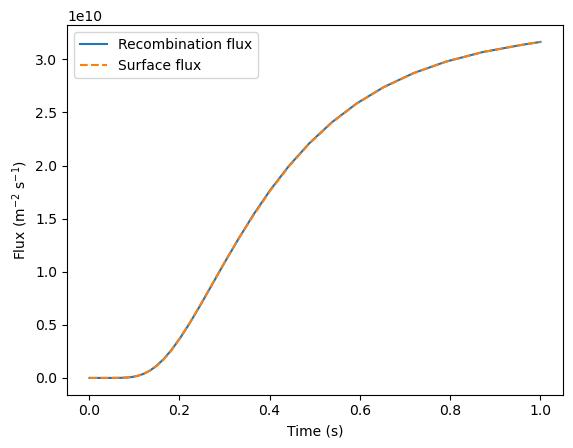

In [16]:
import matplotlib.pyplot as plt

recomb_flux = np.array(derived_quantities[0].data)
surface_flux = -np.array(derived_quantities[1].data)

plt.plot(derived_quantities.t, recomb_flux, label="Recombination flux")
plt.plot(derived_quantities.t, surface_flux, label="Surface flux", linestyle="--")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Flux (m$^{-2}$ s$^{-1}$)")
plt.show()

## Temperature from tabulated data

Using tabulated data for the temperature isn't natively supported in FESTIM. It doesn't mean it's not doable!

Although this requires a bit of FEniCS knowledge, we can extend the `Temperature` class to make it accept an interpolated object from say `scipy.interp1d`.

In [9]:
class InterpolatedExpression(f.UserExpression):
    def __init__(self, f):
        """InterpolatedExpression

        Args:
            f (callable): callable y=f(t) that will be used to evaluate the expression
        """
        super().__init__()
        self.f = f
        self.t = 0

    def eval(self, value, x):
        value[0] = self.f(self.t)


class TemperatureFromData(F.Temperature):
    def __init__(self, f):
        value = InterpolatedExpression(f)
        super().__init__(value)

    # override the create_functions method
    def create_functions(self, mesh):
        """Creates functions self.T, self.T_n

        Args:
            mesh (festim.Mesh): the mesh
        """
        V = f.FunctionSpace(mesh.mesh, "CG", 1)
        self.T = f.Function(V, name="T")
        self.T_n = f.Function(V, name="T_n")
        self.expression = self.value
        self.T.assign(f.interpolate(self.expression, V))
        self.T_n.assign(self.T)

Let's fabricate some tabulated data:

In [10]:
from scipy.interpolate import interp1d

t = np.linspace(0, 10, num=10000)
T = 400 + 10 * np.sin(2 * np.pi * t)

# add noise
T += np.random.normal(0, 1, size=T.shape)

T_f = interp1d(t, T)

We can then use this new custom temperature class in our model.

In [11]:
my_model = F.Simulation()

my_model.mesh = F.MeshFromVertices(np.linspace(0, 3e-6))
my_model.materials = F.Material(id=1, D_0=1e-7, E_D=0.2)


my_model.T = TemperatureFromData(T_f)


my_model.boundary_conditions = [
    F.DirichletBC(surfaces=[1], value=1e15, field=0),
    F.DirichletBC(surfaces=[2], value=0, field=0),
]

my_model.settings = F.Settings(
    absolute_tolerance=1e10, relative_tolerance=1e-10, transient=True, final_time=5
)

my_model.dt = F.Stepsize(0.0005, stepsize_change_ratio=1.1, max_stepsize=0.01)
my_model.exports = [
    F.DerivedQuantities(
        [
            F.AverageVolume("T", volume=1),
            F.SurfaceFlux("0", surface=2),
        ],
        show_units=True,
    )
]

my_model.initialise()

my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        5.0e+00 s    Elapsed time so far: 1.4 s


We can see how this noisy temperature affects the desorption flux:

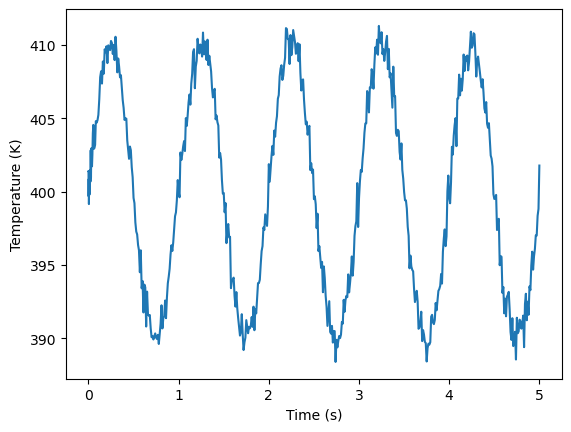

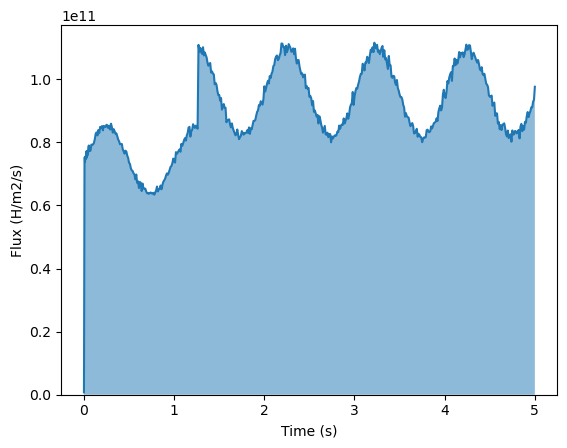

In [12]:
T_t = my_model.exports[0][0].t
T_values = my_model.exports[0][0].data

plt.plot(T_t, T_values)
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.show()

plt.figure()
flux_t = my_model.exports[0][1].t
flux_values = my_model.exports[0][1].data

plt.fill_between(flux_t, np.abs(flux_values), alpha=0.5)
plt.plot(flux_t, np.abs(flux_values))
plt.ylim(bottom=0)
plt.xlabel("Time (s)")
plt.ylabel("Flux (H/m2/s)")
plt.show()

## Customise the `Simulation` class

The same can be done to add some functionality to the `Simulation` class. Here, we want to print the number of iterations at the end of the run.

In [13]:
class CustomSimulation(F.Simulation):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.nb_iterations = 0

    def iterate(self):
        super().iterate()  # do the normal iterate
        self.nb_iterations += 1  # count the iterations

    def run(self):
        super().run()  # run the simulation
        print(f"Completed in {self.nb_iterations} iterations")

In [14]:
my_model = CustomSimulation()

my_model.mesh = F.MeshFromVertices(np.linspace(0, 3e-6))
my_model.materials = F.Material(id=1, D_0=1e-7, E_D=0.2)

my_model.T = 400

my_model.boundary_conditions = [F.DirichletBC(surfaces=[1], value=1e15, field=0)]

my_model.settings = F.Settings(
    absolute_tolerance=1e10, relative_tolerance=1e-10, transient=True, final_time=5
)

my_model.dt = F.Stepsize(1)

my_model.initialise()

my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        5.0e+00 s    Elapsed time so far: 0.0 s
Completed in 5 iterations
